# 2Layer convnet tensorflow

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline


from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("../data", one_hot=True)

Extracting ../data/train-images-idx3-ubyte.gz
Extracting ../data/train-labels-idx1-ubyte.gz
Extracting ../data/t10k-images-idx3-ubyte.gz
Extracting ../data/t10k-labels-idx1-ubyte.gz


In [2]:
#sanity check
print("My data looks like:\n")
print(" Training images: {}\n Training labels: {} ".format(len(data.train.images), len(data.train.labels)))
print(" Test images: {}\n Test labels: {}".format(len(data.test.images), len(data.test.labels)))

My data looks like:

 Training images: 55000
 Training labels: 55000 
 Test images: 10000
 Test labels: 10000


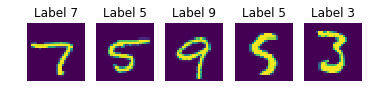

In [3]:
#visualise a few examples
samples = np.random.randint(55000, size=(5))

for ind, sample in enumerate(samples):
    image = data.train.images[sample].reshape(28, 28)
    labelVal = np.argmax(data.train.labels[sample], axis=0)
    label = "Label " + str(labelVal)
    plt.subplot(1, 5, ind+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(label)

In [66]:
#images are wrong shape for cnn so need to be shaped in order to retain spacial information
print("dimensions of training images: ", data.train.images.shape)
print("dimensions of test images: ", data.test.images.shape)
print("reshape.. ")
train_images = data.train.images.reshape(55000, 28, 28)
test_images = data.test.images.reshape(10000, 28, 28)
print("dimensions of training images: ", train_images.shape)
print("dimensions of training images: ", test_images.shape)



dimensions of training images:  (55000, 784)
dimensions of test images:  (10000, 784)
reshape.. 
dimensions of training images:  (55000, 28, 28)
dimensions of training images:  (10000, 28, 28)


In [4]:
# create actual numeric versions of label data
print(data.train.labels.shape)
train_label_cls = np.argmax(data.train.labels, axis=0)
test_label_cls = np.array([label.argmax() for label in data.test.labels])

(55000, 10)


In [5]:
tf.reset_default_graph()

#create TF Placeholders

x = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])
y_class = tf.placeholder(tf.int64, [None])

#create TF Variables

#conv layers
c1 = tf.get_variable('c1', [5, 5, 1 , 16])
c1b = tf.get_variable('cb1', [16])

c2 = tf.get_variable('c2', [5, 5, 16, 32])
c2b = tf.get_variable('cb2', [32])

#batchnorm
bn_gamma = tf.get_variable('bn_gamma', shape=[16])
bn_beta = tf.get_variable('bn_beta', shape=[16])


#affine
affine1 = tf.get_variable('affine1', [(14 * 14* 32) , 100])
a1b = tf.get_variable('a1b', [100])
affine2 = tf.get_variable('affine2', [100, 10])
a2b = tf.get_variable('a2b', [10])


## define comp graph
x_img = tf.reshape(x, [-1, 28, 28, 1])
c1_out = tf.nn.conv2d(x_img, c1, strides=[1,1,1,1], padding='SAME') + c1b
c1_out = tf.nn.relu(c1_out)
c1_pool = tf.layers.max_pooling2d(inputs=c1_out, pool_size=[2, 2], strides=2)

c2_out = tf.nn.conv2d(c1_pool, c2, strides=[1, 1, 1, 1], padding='SAME') + c2b
c2_out = tf.nn.relu(c2_out)
c2_flat = tf.reshape(c2_out, [-1, (14 * 14* 32) ])
print(c2_out.get_shape)
a1_out = tf.matmul(c2_flat, affine1) + a1b
logits = tf.matmul(a1_out, affine2) + a2b
print(logits.get_shape)
# loss and cost
predictions = tf.nn.softmax(logits)
predicted_class = tf.argmax(predictions, axis=1)

total_loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
mean_loss = tf.reduce_mean(total_loss)

#optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=5e-4).minimize(mean_loss)

#have TF compute accuracy
correct_prediction = tf.equal(predicted_class, y_class)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


<bound method Tensor.get_shape of <tf.Tensor 'Relu_1:0' shape=(?, 14, 14, 32) dtype=float32>>
<bound method Tensor.get_shape of <tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>>


In [6]:
# Prepare for session run
session = tf.Session()

#init variables
session.run(tf.global_variables_initializer())


In [7]:
batch_size = 100

In [8]:
def train(num_its):
    for i in range(num_its):
        x_batch, y_batch = data.train.next_batch(batch_size)
        training_feed_dict = {x: x_batch, y: y_batch}
        session.run(optimizer, training_feed_dict)

In [9]:
train(1000)

In [10]:
test_feed_dict = {x: data.test.images, y: data.test.labels, y_class: test_label_cls}
acc = session.run(accuracy, feed_dict=test_feed_dict)
print("test set accuracy is {0:.1%}".format(acc))

test set accuracy is 98.6%


In [ ]:
session.close()